In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
import holidays
import glob

In [2]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform
import matplotlib.pyplot as plt

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

## 잠실새내역 5번 출구 뒤 데이터 처리
- 컬럼 설명
- 대여 거치대 : 0 = QR, 99 = 새싹, 1~98 = LCD 거치대(예전)
- 반납 거치대 : 0 = QR, 99 = 새싹, 1~98 = LCD 거치대(예전)
- 이용 거리 : (0 또는 매우 높은 숫자)는 오류, M
- 이용 시간 : minute
- 대여, 반납 대여소 ID : 내부 프로그램 관리용 ID (대여소 번호와 동일한 기능)




In [3]:
# 송파구 따릉이 대여이력 데이터 
df=pd.read_csv('../../Data/송파반납대여.csv')


In [4]:
# 대여, 반납이 잠실새내역 5번출구 인 것만 추출 
df_jamsil=df[(df['대여 대여소번호'] ==1222) | (df['반납대여소번호'] ==1222)]

In [5]:
# index 정리
df_jamsil.reset_index(drop=True, inplace= True)

In [6]:
df_jamsil.head()

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간(분),이용거리(M),생년,성별,이용자종류,대여대여소ID,반납대여소ID,자전거구분,자치구,반납 자치구
0,SPB-66413,2024-04-01 00:05:50,1231,잠실역 6번출구,0,2024-04-01 00:12:36,1222.0,잠실새내역 5번 출구 뒤,0,6,1320.00,1997,M,내국인,ST-840,ST-547,일반자전거,송파구,송파구
1,SPB-66193,2024-04-01 00:14:31,1222,잠실새내역 5번 출구 뒤,0,2024-04-01 00:25:37,4897.0,잠실주공5단지1,0,11,1263.75,1999,F,내국인,ST-547,ST-2991,일반자전거,송파구,송파구
2,SPB-43542,2024-04-01 00:32:22,2646,레이크펠리스101동앞,0,2024-04-01 00:39:11,1222.0,잠실새내역 5번 출구 뒤,0,6,813.88,1979,M,내국인,ST-1867,ST-547,일반자전거,송파구,송파구
3,SPB-66954,2024-04-01 01:23:55,1222,잠실새내역 5번 출구 뒤,0,2024-04-01 01:44:58,1210.0,롯데월드타워(잠실역2번출구 쪽),0,21,1460.00,1994,M,내국인,ST-547,ST-891,일반자전거,송파구,송파구
4,SPB-53540,2024-04-01 00:48:12,2348,포스코사거리(기업은행),0,2024-04-01 01:53:14,1222.0,잠실새내역 5번 출구 뒤,0,65,5785.36,1996,F,내국인,ST-797,ST-547,일반자전거,강남구,송파구


In [7]:
df_jamsil.drop(['대여대여소ID','반납대여소ID'], axis=1, inplace= True)

In [8]:
# 잠실새내역 5번 출구 뒤 대여소의 대여, 반납이력 데이터만 추출 
jamsil_5 =df_jamsil[(df_jamsil['대여 대여소번호'] == 1222) |(df_jamsil['반납대여소번호'] ==1222)]

In [9]:
# 인덱스 정리하기
jamsil_5.reset_index(drop=True, inplace= True)

In [10]:
jamsil_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120229 entries, 0 to 120228
Data columns (total 17 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   자전거번호     120229 non-null  object 
 1   대여일시      120229 non-null  object 
 2   대여 대여소번호  120229 non-null  int64  
 3   대여 대여소명   120229 non-null  object 
 4   대여거치대     120229 non-null  int64  
 5   반납일시      120229 non-null  object 
 6   반납대여소번호   119977 non-null  float64
 7   반납대여소명    120229 non-null  object 
 8   반납거치대     120229 non-null  object 
 9   이용시간(분)   120229 non-null  int64  
 10  이용거리(M)   120229 non-null  float64
 11  생년        120229 non-null  object 
 12  성별        116945 non-null  object 
 13  이용자종류     120229 non-null  object 
 14  자전거구분     95302 non-null   object 
 15  자치구       119036 non-null  object 
 16  반납 자치구    118922 non-null  object 
dtypes: float64(2), int64(3), object(12)
memory usage: 15.6+ MB


> 반납 거치대: Object => 데이터에 text 숨어있을 가능성


In [11]:
# 이상한 데이터 
print(f'{jamsil_5['반납거치대'].unique()}')
# \\n => nan 처리하기
jamsil_5['반납거치대']=jamsil_5['반납거치대'].replace('\\N',np.nan)

['0' '99' '\\N']


In [12]:
jamsil_5['반납거치대'].unique()

array(['0', '99', nan], dtype=object)

In [13]:
# 반납 거치대 컬럼 타입 변경
jamsil_5['반납거치대']=jamsil_5['반납거치대'].astype('float')

In [14]:
jamsil_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120229 entries, 0 to 120228
Data columns (total 17 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   자전거번호     120229 non-null  object 
 1   대여일시      120229 non-null  object 
 2   대여 대여소번호  120229 non-null  int64  
 3   대여 대여소명   120229 non-null  object 
 4   대여거치대     120229 non-null  int64  
 5   반납일시      120229 non-null  object 
 6   반납대여소번호   119977 non-null  float64
 7   반납대여소명    120229 non-null  object 
 8   반납거치대     119955 non-null  float64
 9   이용시간(분)   120229 non-null  int64  
 10  이용거리(M)   120229 non-null  float64
 11  생년        120229 non-null  object 
 12  성별        116945 non-null  object 
 13  이용자종류     120229 non-null  object 
 14  자전거구분     95302 non-null   object 
 15  자치구       119036 non-null  object 
 16  반납 자치구    118922 non-null  object 
dtypes: float64(3), int64(3), object(11)
memory usage: 15.6+ MB


> 다른 object type의 컬럼에도 \\\N 값 있는지 확인 필요

In [15]:
# \\N 값 확인
for col in jamsil_5.columns:
    print(f'{col} : {(jamsil_5[col] == '\\N').sum()}')
# 반납 대여소명 : 252
# 생년 : 9973
# 성별 : 32074

자전거번호 : 0
대여일시 : 0
대여 대여소번호 : 0
대여 대여소명 : 0
대여거치대 : 0
반납일시 : 0
반납대여소번호 : 0
반납대여소명 : 252
반납거치대 : 0
이용시간(분) : 0
이용거리(M) : 0
생년 : 9973
성별 : 32074
이용자종류 : 0
자전거구분 : 0
자치구 : 0
반납 자치구 : 0


In [16]:
# 반납 대여소명, 생년, 성별 컬럼의 \\N 값을 NaN 으로 변경
jamsil_5['반납대여소명'].replace('\\N', np.nan,inplace=True)
jamsil_5['생년'].replace('\\N', np.nan, inplace=True)
jamsil_5['성별'].replace('\\N', np.nan, inplace = True)

<Axes: >

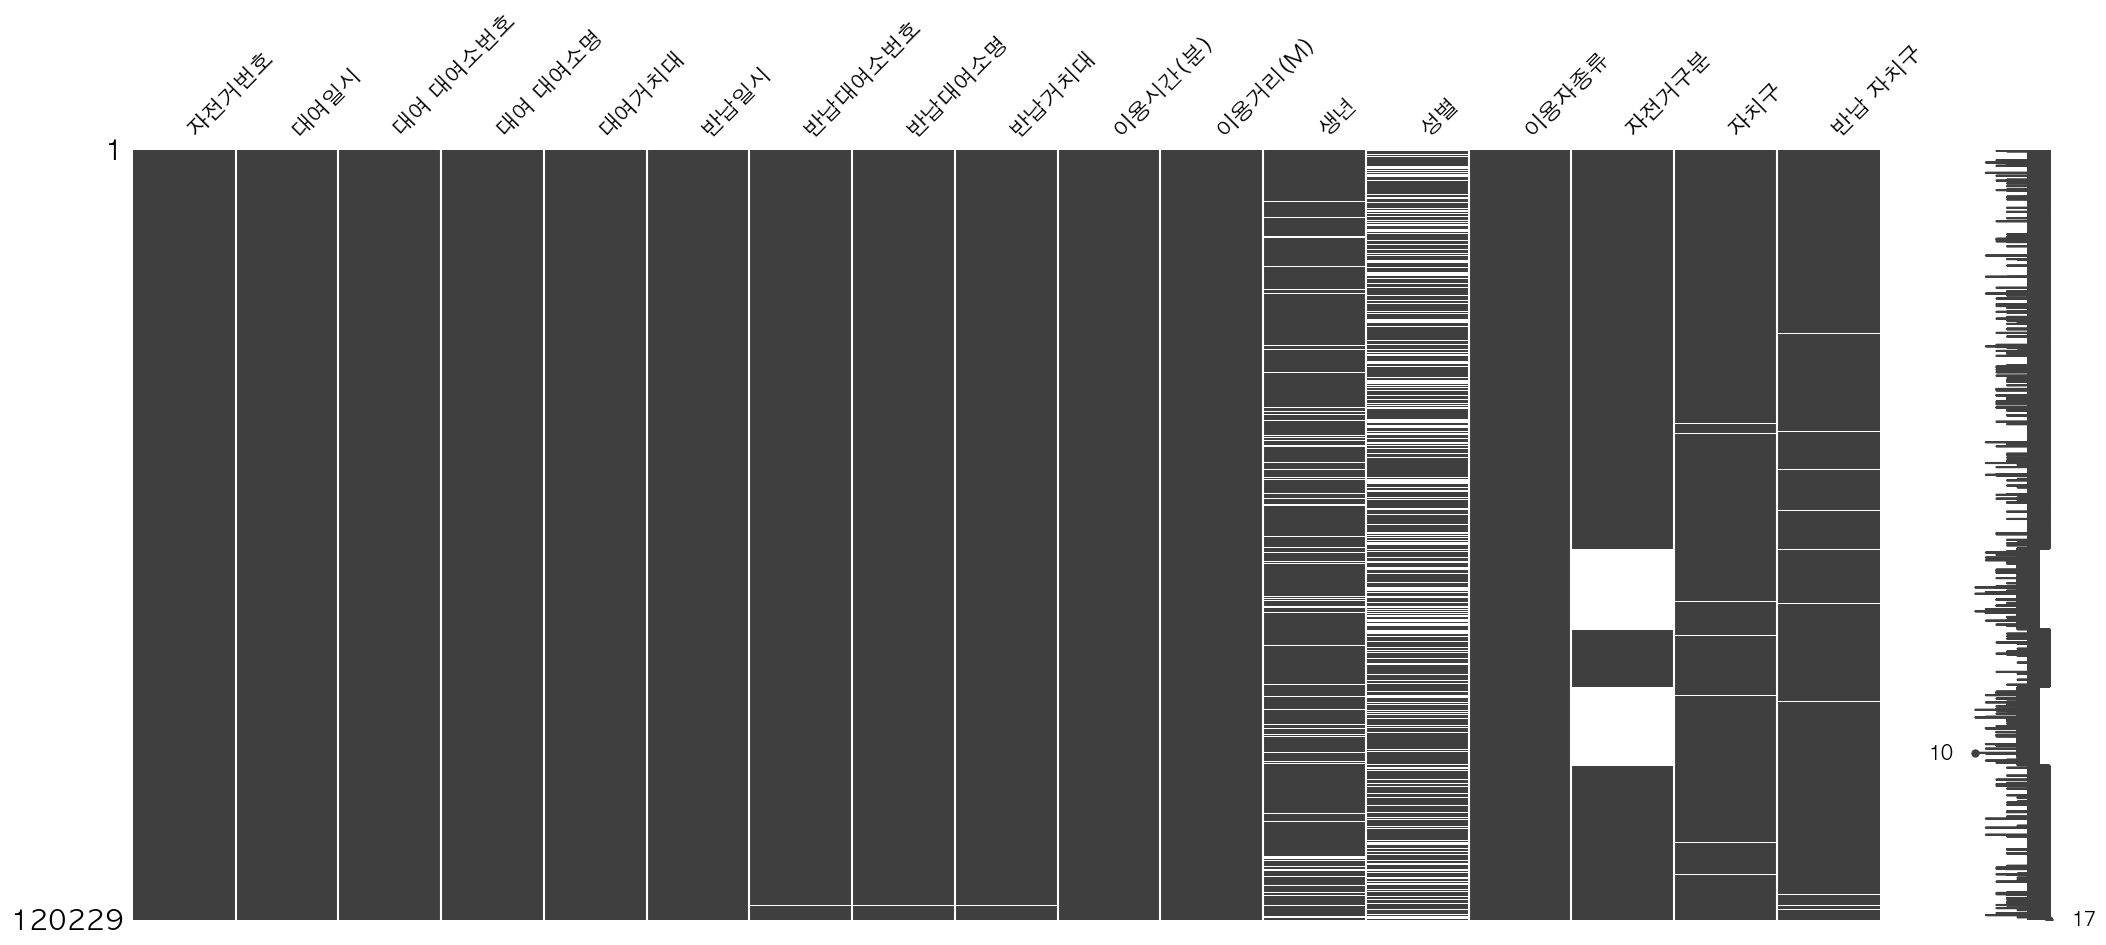

In [17]:
# 결측치확인
msno.matrix(jamsil_5)

> 성별 결측치 : 회원가입 성별 미입력 or 비회원              
     자전거 구분 : 확인필요                
     자치구 : 강제 반납으로 인한 반납대여소명 특정 불가               
     반납 자치구 : 자치구와 같음
     반납 거치대 : 확인 필요

In [18]:
jamsil_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120229 entries, 0 to 120228
Data columns (total 17 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   자전거번호     120229 non-null  object 
 1   대여일시      120229 non-null  object 
 2   대여 대여소번호  120229 non-null  int64  
 3   대여 대여소명   120229 non-null  object 
 4   대여거치대     120229 non-null  int64  
 5   반납일시      120229 non-null  object 
 6   반납대여소번호   119977 non-null  float64
 7   반납대여소명    119977 non-null  object 
 8   반납거치대     119955 non-null  float64
 9   이용시간(분)   120229 non-null  int64  
 10  이용거리(M)   120229 non-null  float64
 11  생년        110256 non-null  object 
 12  성별        84871 non-null   object 
 13  이용자종류     120229 non-null  object 
 14  자전거구분     95302 non-null   object 
 15  자치구       119036 non-null  object 
 16  반납 자치구    118922 non-null  object 
dtypes: float64(3), int64(3), object(11)
memory usage: 15.6+ MB


In [19]:
# 성별 컬럼 삭제하기
jamsil_5.drop('성별',axis=1, inplace= True)

In [20]:
jamsil_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120229 entries, 0 to 120228
Data columns (total 16 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   자전거번호     120229 non-null  object 
 1   대여일시      120229 non-null  object 
 2   대여 대여소번호  120229 non-null  int64  
 3   대여 대여소명   120229 non-null  object 
 4   대여거치대     120229 non-null  int64  
 5   반납일시      120229 non-null  object 
 6   반납대여소번호   119977 non-null  float64
 7   반납대여소명    119977 non-null  object 
 8   반납거치대     119955 non-null  float64
 9   이용시간(분)   120229 non-null  int64  
 10  이용거리(M)   120229 non-null  float64
 11  생년        110256 non-null  object 
 12  이용자종류     120229 non-null  object 
 13  자전거구분     95302 non-null   object 
 14  자치구       119036 non-null  object 
 15  반납 자치구    118922 non-null  object 
dtypes: float64(3), int64(3), object(10)
memory usage: 14.7+ MB


In [21]:
jamsil_5.describe()

,대여 대여소번호,대여거치대,반납대여소번호,반납거치대,이용시간(분),이용거리(M)
count,120229.000000,120229.000000,119977.000000,119955.000000,120229.000000,120229.000000
mean,1865.741743,3.832237,1886.589138,3.813755,25.231675,2791.018406
std,1196.993620,19.097341,1224.755933,19.053085,32.278882,3468.681250
min,104.000000,0.000000,103.000000,0.000000,0.000000,0.000000
25%,1222.000000,0.000000,1222.000000,0.000000,6.000000,780.000000
50%,1222.000000,0.000000,1222.000000,0.000000,13.000000,1474.370000
75%,2431.000000,0.000000,2608.000000,0.000000,34.000000,3428.700000
max,5870.000000,99.000000,5870.000000,99.000000,1404.000000,101241.420000


In [22]:
jamsil_5['대여일시']=pd.to_datetime(jamsil_5['대여일시'])
jamsil_5['반납일시']=pd.to_datetime(jamsil_5['반납일시'])

In [23]:
# 이용거리, 이용시간이 0인 데이터는 삭제
jamsil_5=(jamsil_5[(jamsil_5['이용거리(M)'] != 0) &(jamsil_5['이용시간(분)'] !=0)])

In [24]:
# 조건에 따라 NaN 값을 채우는 함수 정의
def fill_bike_type(row):
    if pd.isna(row['자전거구분']):
        if row['대여거치대'] == 0:
            return '일반자전거'
        elif row['대여거치대'] == 99:
            return '새싹자전거'
    return row['자전거구분']

# apply 함수를 사용하여 NaN 값 채우기
jamsil_5['자전거구분'] = jamsil_5.apply(fill_bike_type, axis=1)

# 결과 확인
print(jamsil_5[['대여거치대', '자전거구분']].head())

   대여거치대  자전거구분
0      0  일반자전거
1      0  일반자전거
2      0  일반자전거
3      0  일반자전거
4      0  일반자전거


In [25]:
jamsil_5[(jamsil_5['대여일시'] >= pd.to_datetime('2023-06-01')) & (jamsil_5['대여일시'] <= pd.to_datetime('2023-07-01')) & (jamsil_5['대여 대여소번호']==1222)]

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간(분),이용거리(M),생년,이용자종류,자전거구분,자치구,반납 자치구
83872,SPB-54607,2023-06-01 01:05:29,1222,잠실새내역 5번 출구 뒤,0,2023-06-01 01:56:54,3505.0,신양초교앞 교차로,0.0,51,5618.21,2001,내국인,일반자전거,송파구,광진구
83874,SPB-47956,2023-06-01 01:50:51,1222,잠실새내역 5번 출구 뒤,0,2023-06-01 02:01:32,4859.0,잠실나루 나들목,0.0,10,2160.00,1977,내국인,일반자전거,송파구,송파구
83875,SPB-36552,2023-06-01 02:02:09,1222,잠실새내역 5번 출구 뒤,0,2023-06-01 02:13:02,4452.0,삼성SDS,0.0,10,1854.67,1994,내국인,일반자전거,송파구,송파구
83876,SPB-65610,2023-06-01 02:02:44,1222,잠실새내역 5번 출구 뒤,0,2023-06-01 02:13:18,4452.0,삼성SDS,0.0,10,1673.98,1994,내국인,일반자전거,송파구,송파구
83878,SPB-32479,2023-06-01 01:59:03,1222,잠실새내역 5번 출구 뒤,0,2023-06-01 02:15:12,1209.0,잠실나루역 (2번 출구 쪽),0.0,16,2309.19,1977,내국인,일반자전거,송파구,송파구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96185,SPB-63246,2023-06-30 23:56:07,1222,잠실새내역 5번 출구 뒤,0,2023-07-01 00:04:58,4897.0,잠실주공5단지1,0.0,8,992.43,2001,내국인,일반자전거,송파구,송파구
96187,SPB-63061,2023-06-30 23:58:19,1222,잠실새내역 5번 출구 뒤,0,2023-07-01 00:12:03,1209.0,잠실나루역 (2번 출구 쪽),0.0,13,2450.00,1990,내국인,일반자전거,송파구,송파구
96189,SPB-47864,2023-06-30 23:19:07,1222,잠실새내역 5번 출구 뒤,0,2023-07-01 00:20:59,1210.0,롯데월드타워(잠실역2번출구 쪽),0.0,61,2497.25,2000,내국인,일반자전거,송파구,송파구
96190,SPB-38490,2023-06-30 23:51:33,1222,잠실새내역 5번 출구 뒤,0,2023-07-01 00:31:44,2644.0,성내5교,0.0,40,7485.20,1994,내국인,일반자전거,송파구,송파구


In [26]:
jamsil_5.reset_index(drop=True, inplace= True)

In [27]:
# 일반자전거 데이터만 활용하기
jamsil_5 = jamsil_5[jamsil_5['자전거구분'] =='일반자전거']

In [28]:
jamsil_5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111232 entries, 0 to 115501
Data columns (total 16 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   자전거번호     111232 non-null  object        
 1   대여일시      111232 non-null  datetime64[ns]
 2   대여 대여소번호  111232 non-null  int64         
 3   대여 대여소명   111232 non-null  object        
 4   대여거치대     111232 non-null  int64         
 5   반납일시      111232 non-null  datetime64[ns]
 6   반납대여소번호   111037 non-null  float64       
 7   반납대여소명    111037 non-null  object        
 8   반납거치대     111018 non-null  float64       
 9   이용시간(분)   111232 non-null  int64         
 10  이용거리(M)   111232 non-null  float64       
 11  생년        102096 non-null  object        
 12  이용자종류     111232 non-null  object        
 13  자전거구분     111232 non-null  object        
 14  자치구       110101 non-null  object        
 15  반납 자치구    110059 non-null  object        
dtypes: datetime64[ns](2), float64(3), int64(3),

In [29]:
# 필요없는 컬럼 삭제하기
jamsil_5.drop(['생년','이용자종류','대여거치대','반납거치대','자전거구분'],axis=1, inplace= True)

In [30]:
jamsil_5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111232 entries, 0 to 115501
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   자전거번호     111232 non-null  object        
 1   대여일시      111232 non-null  datetime64[ns]
 2   대여 대여소번호  111232 non-null  int64         
 3   대여 대여소명   111232 non-null  object        
 4   반납일시      111232 non-null  datetime64[ns]
 5   반납대여소번호   111037 non-null  float64       
 6   반납대여소명    111037 non-null  object        
 7   이용시간(분)   111232 non-null  int64         
 8   이용거리(M)   111232 non-null  float64       
 9   자치구       110101 non-null  object        
 10  반납 자치구    110059 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(5)
memory usage: 10.2+ MB


In [31]:
# 대여, 반납 분리하기
jamsil5_rent=jamsil_5[jamsil_5['대여 대여소번호'] == 1222]
jamsil5_return=jamsil_5[jamsil_5['반납대여소번호'] == 1222]

In [32]:
# index 정리
jamsil5_rent.reset_index(drop=True, inplace= True)
jamsil5_return.reset_index(drop=True, inplace= True)

In [33]:
jamsil5_rent.head()

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,반납일시,반납대여소번호,반납대여소명,이용시간(분),이용거리(M),자치구,반납 자치구
0,SPB-66193,2024-04-01 00:14:31,1222,잠실새내역 5번 출구 뒤,2024-04-01 00:25:37,4897.0,잠실주공5단지1,11,1263.75,송파구,송파구
1,SPB-66954,2024-04-01 01:23:55,1222,잠실새내역 5번 출구 뒤,2024-04-01 01:44:58,1210.0,롯데월드타워(잠실역2번출구 쪽),21,1460.00,송파구,송파구
2,SPB-51184,2024-04-01 02:08:16,1222,잠실새내역 5번 출구 뒤,2024-04-01 02:19:48,1222.0,잠실새내역 5번 출구 뒤,11,1488.79,송파구,송파구
3,SPB-49137,2024-04-01 03:09:00,1222,잠실새내역 5번 출구 뒤,2024-04-01 03:25:44,5756.0,극동아파트,16,3370.00,송파구,송파구
4,SPB-41864,2024-04-01 03:31:14,1222,잠실새내역 5번 출구 뒤,2024-04-01 03:44:05,1226.0,잠실4동 주민센터 옆,12,2882.81,송파구,송파구


In [34]:
# 1222 : 잠실새내역5번출구뒤 
jamsil5_rent['반납대여소번호'].value_counts(ascending=False)

반납대여소번호
1222.0    4535
2645.0    3231
4897.0    2481
1224.0    2408
4483.0    2186
          ... 
4791.0       1
2256.0       1
4136.0       1
2540.0       1
1519.0       1
Name: count, Length: 904, dtype: int64

In [35]:
jamsil5_rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57446 entries, 0 to 57445
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   자전거번호     57446 non-null  object        
 1   대여일시      57446 non-null  datetime64[ns]
 2   대여 대여소번호  57446 non-null  int64         
 3   대여 대여소명   57446 non-null  object        
 4   반납일시      57446 non-null  datetime64[ns]
 5   반납대여소번호   57251 non-null  float64       
 6   반납대여소명    57251 non-null  object        
 7   이용시간(분)   57446 non-null  int64         
 8   이용거리(M)   57446 non-null  float64       
 9   자치구       57446 non-null  object        
 10  반납 자치구    56273 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(5)
memory usage: 4.8+ MB


In [36]:
# 대여테이블에서 필요없는 컬럼 삭제하기
jamsil5_rent.drop(['자전거번호','반납 자치구','자치구','반납일시','반납대여소번호','반납대여소명'], axis=1 , inplace= True) 

In [37]:
jamsil5_rent['대여일시']=pd.to_datetime(jamsil5_rent['대여일시'])

In [38]:
jamsil5_rent['년도'] = jamsil5_rent['대여일시'].dt.year
jamsil5_rent['월'] = jamsil5_rent['대여일시'].dt.month
jamsil5_rent['일'] = jamsil5_rent['대여일시'].dt.day
jamsil5_rent['시간'] = jamsil5_rent['대여일시'].dt.hour

In [39]:
jamsil5_rent.describe()

,대여일시,대여 대여소번호,이용시간(분),이용거리(M),년도,월,일,시간
count,57446,57446.0,57446.000000,57446.000000,57446.000000,57446.000000,57446.000000,57446.000000
mean,2023-11-06 20:05:41.670246656,1222.0,27.776956,2961.243699,2023.350555,6.506545,15.476726,15.137155
min,2023-05-01 00:19:04,1222.0,1.000000,0.100000,2023.000000,1.000000,1.000000,0.000000
25%,2023-07-20 08:09:28.750000128,1222.0,7.000000,910.000000,2023.000000,5.000000,8.000000,12.000000
50%,2023-10-16 19:04:51,1222.0,15.000000,1606.975000,2023.000000,6.000000,15.000000,17.000000
75%,2024-03-15 21:23:20,1222.0,37.000000,3683.797500,2024.000000,9.000000,23.000000,19.000000
max,2024-05-31 23:37:34,1222.0,1241.000000,101241.420000,2024.000000,12.000000,31.000000,23.000000
std,NaN,0.0,32.890702,3538.619444,0.477148,2.879478,8.905289,5.668816


In [40]:
# 반납 테이블 확인
jamsil5_return.head()

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,반납일시,반납대여소번호,반납대여소명,이용시간(분),이용거리(M),자치구,반납 자치구
0,SPB-66413,2024-04-01 00:05:50,1231,잠실역 6번출구,2024-04-01 00:12:36,1222.0,잠실새내역 5번 출구 뒤,6,1320.00,송파구,송파구
1,SPB-43542,2024-04-01 00:32:22,2646,레이크펠리스101동앞,2024-04-01 00:39:11,1222.0,잠실새내역 5번 출구 뒤,6,813.88,송파구,송파구
2,SPB-53540,2024-04-01 00:48:12,2348,포스코사거리(기업은행),2024-04-01 01:53:14,1222.0,잠실새내역 5번 출구 뒤,65,5785.36,강남구,송파구
3,SPB-51184,2024-04-01 02:08:16,1222,잠실새내역 5번 출구 뒤,2024-04-01 02:19:48,1222.0,잠실새내역 5번 출구 뒤,11,1488.79,송파구,송파구
4,SPB-57930,2024-04-01 02:20:33,1221,삼전역 4번출구,2024-04-01 02:29:30,1222.0,잠실새내역 5번 출구 뒤,8,892.33,송파구,송파구


In [41]:
jamsil5_return.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58321 entries, 0 to 58320
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   자전거번호     58321 non-null  object        
 1   대여일시      58321 non-null  datetime64[ns]
 2   대여 대여소번호  58321 non-null  int64         
 3   대여 대여소명   58321 non-null  object        
 4   반납일시      58321 non-null  datetime64[ns]
 5   반납대여소번호   58321 non-null  float64       
 6   반납대여소명    58321 non-null  object        
 7   이용시간(분)   58321 non-null  int64         
 8   이용거리(M)   58321 non-null  float64       
 9   자치구       57190 non-null  object        
 10  반납 자치구    58321 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(5)
memory usage: 4.9+ MB


In [42]:
# 필요없는 컬럼 제거
jamsil5_return.drop(['자전거번호','대여일시','대여 대여소번호','대여 대여소명','자치구','반납 자치구'],axis=1, inplace= True)

In [43]:
jamsil5_return['반납일시']=pd.to_datetime(jamsil5_return['반납일시'])

In [44]:
jamsil5_return['년도']=jamsil5_return['반납일시'].dt.year
jamsil5_return['월']=jamsil5_return['반납일시'].dt.month
jamsil5_return['일']=jamsil5_return['반납일시'].dt.day
jamsil5_return['시간']=jamsil5_return['반납일시'].dt.hour

In [45]:
# 대한민국 공휴일 가져오기
kr_holidays = holidays.KR(years=range(2020,2025))

# 날짜가 공휴일인지를 체크하는 함수 추가
# 공휴일 : 2, 주말 : 1, 평일 : 0
jamsil5_rent['휴일여부'] = jamsil5_rent['대여일시'].dt.date.apply(lambda x: 2 if x in kr_holidays else (1 if x.weekday() >= 5 else 0))


In [46]:
# 대한민국 공휴일 가져오기
kr_holidays = holidays.KR(years=range(2020,2025))

# 날짜가 공휴일인지를 체크하는 함수 추가
jamsil5_return['휴일여부'] = jamsil5_return['반납일시'].dt.date.apply(lambda x: 2 if x in kr_holidays else (1 if x.weekday() >= 5 else 0))


In [47]:
jamsil5_rent.drop(['이용시간(분)','이용거리(M)'],axis=1, inplace= True)
jamsil5_return.drop(['이용시간(분)','이용거리(M)'],axis=1, inplace= True)

In [48]:
jamsil5_return['요일']=jamsil5_return['반납일시'].dt.dayofweek
jamsil5_rent['요일']=jamsil5_rent['대여일시'].dt.dayofweek

In [49]:
jamsil5_rent

,대여일시,대여 대여소번호,대여 대여소명,년도,월,일,시간,휴일여부,요일
0,2024-04-01 00:14:31,1222,잠실새내역 5번 출구 뒤,2024,4,1,0,0,0
1,2024-04-01 01:23:55,1222,잠실새내역 5번 출구 뒤,2024,4,1,1,0,0
2,2024-04-01 02:08:16,1222,잠실새내역 5번 출구 뒤,2024,4,1,2,0,0
3,2024-04-01 03:09:00,1222,잠실새내역 5번 출구 뒤,2024,4,1,3,0,0
4,2024-04-01 03:31:14,1222,잠실새내역 5번 출구 뒤,2024,4,1,3,0,0
...,...,...,...,...,...,...,...,...,...
57441,2023-09-30 23:59:04,1222,잠실새내역 5번 출구 뒤,2023,9,30,23,2,5
57442,2023-09-30 23:43:56,1222,잠실새내역 5번 출구 뒤,2023,9,30,23,2,5
57443,2023-09-30 23:34:24,1222,잠실새내역 5번 출구 뒤,2023,9,30,23,2,5
57444,2023-09-30 23:32:35,1222,잠실새내역 5번 출구 뒤,2023,9,30,23,2,5


In [50]:
jamsil5_rent['date'] = jamsil5_rent['대여일시'].dt.date
jamsil5_return['date'] = jamsil5_return['반납일시'].dt.date

In [51]:
jamsil5_return.drop('반납일시',axis=1, inplace= True)
jamsil5_rent.drop('대여일시',axis=1, inplace= True)

In [52]:
jamsil5_rent.info()
jamsil5_return.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57446 entries, 0 to 57445
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   대여 대여소번호  57446 non-null  int64 
 1   대여 대여소명   57446 non-null  object
 2   년도        57446 non-null  int32 
 3   월         57446 non-null  int32 
 4   일         57446 non-null  int32 
 5   시간        57446 non-null  int32 
 6   휴일여부      57446 non-null  int64 
 7   요일        57446 non-null  int32 
 8   date      57446 non-null  object
dtypes: int32(5), int64(2), object(2)
memory usage: 2.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58321 entries, 0 to 58320
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   반납대여소번호  58321 non-null  float64
 1   반납대여소명   58321 non-null  object 
 2   년도       58321 non-null  int32  
 3   월        58321 non-null  int32  
 4   일        58321 non-null  int32  
 5   시간       58321 non-null  int32  
 6

In [53]:
jamsil5_rent['date']=pd.to_datetime(jamsil5_rent['date'])
jamsil5_return['date']=pd.to_datetime(jamsil5_return['date'])

------
## 날씨 데이터 병합하기

In [54]:
weather = pd.read_csv('../../data/송파구날씨통합.csv')

In [55]:
weather

,지점,지점명,일시,기온(°C),강수량(mm),습도(%),전운량(10분위),시정(10m),date,시간,PM10,PM25
0,108,서울,2023-05-01 00:00:00,12.1,0.0,87,9,1049,2023-05-01,0,67.0,30.0
1,108,서울,2023-05-01 01:00:00,11.6,0.0,88,6,957,2023-05-01,1,66.0,26.0
2,108,서울,2023-05-01 02:00:00,11.0,0.0,90,6,778,2023-05-01,2,64.0,28.0
3,108,서울,2023-05-01 03:00:00,10.8,0.0,91,8,672,2023-05-01,3,58.0,22.0
4,108,서울,2023-05-01 04:00:00,10.4,0.0,92,8,633,2023-05-01,4,56.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9523,108,서울,2024-05-31 19:00:00,18.7,1.0,65,8,3671,2024-05-31,19,17.0,4.0
9524,108,서울,2024-05-31 20:00:00,18.4,0.0,68,8,3216,2024-05-31,20,10.0,1.0
9525,108,서울,2024-05-31 21:00:00,18.7,0.0,67,9,3449,2024-05-31,21,13.0,4.0
9526,108,서울,2024-05-31 22:00:00,18.8,0.0,73,10,2528,2024-05-31,22,16.0,11.0


In [56]:
# 각 날짜별 PM10의 평균 계산
mean_pm10_by_date = weather.groupby('date')['PM10'].mean()

# NaN 값을 해당 날짜의 평균으로 대체
weather['PM10'] = weather['PM10'].fillna(weather['date'].map(mean_pm10_by_date))

In [57]:
# 각 날짜별 PM25의 평균 계산
mean_PM25_by_date = weather.groupby('date')['PM25'].mean()

# NaN 값을 해당 날짜의 평균으로 대체
weather['PM25'] = weather['PM25'].fillna(weather['date'].map(mean_PM25_by_date))

In [58]:
weather['date']=pd.to_datetime(weather['date'])

In [59]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9528 entries, 0 to 9527
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   지점         9528 non-null   int64         
 1   지점명        9528 non-null   object        
 2   일시         9528 non-null   object        
 3   기온(°C)     9528 non-null   float64       
 4   강수량(mm)    9528 non-null   float64       
 5   습도(%)      9528 non-null   int64         
 6   전운량(10분위)  9528 non-null   int64         
 7   시정(10m)    9528 non-null   int64         
 8   date       9528 non-null   datetime64[ns]
 9   시간         9528 non-null   int64         
 10  PM10       9528 non-null   float64       
 11  PM25       9528 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(5), object(2)
memory usage: 893.4+ KB


In [60]:
# merge를 위해 날짜 기간 맞추기
weather=weather[weather['date'] >= pd.to_datetime('2023-06-01')]

In [61]:
weather['date'].describe()

count                   8784
mean     2023-11-30 12:00:00
min      2023-06-01 00:00:00
25%      2023-08-31 00:00:00
50%      2023-11-30 12:00:00
75%      2024-03-01 00:00:00
max      2024-05-31 00:00:00
Name: date, dtype: object

In [62]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8784 entries, 744 to 9527
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   지점         8784 non-null   int64         
 1   지점명        8784 non-null   object        
 2   일시         8784 non-null   object        
 3   기온(°C)     8784 non-null   float64       
 4   강수량(mm)    8784 non-null   float64       
 5   습도(%)      8784 non-null   int64         
 6   전운량(10분위)  8784 non-null   int64         
 7   시정(10m)    8784 non-null   int64         
 8   date       8784 non-null   datetime64[ns]
 9   시간         8784 non-null   int64         
 10  PM10       8784 non-null   float64       
 11  PM25       8784 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(5), object(2)
memory usage: 892.1+ KB


In [63]:
weather.iloc[:,3:]

,기온(°C),강수량(mm),습도(%),전운량(10분위),시정(10m),date,시간,PM10,PM25
744,20.7,0.0,66,10,2000,2023-06-01,0,40.0,20.0
745,20.5,0.0,67,10,2000,2023-06-01,1,39.0,24.0
746,20.4,0.0,69,10,2000,2023-06-01,2,40.0,27.0
747,20.1,0.0,70,10,2000,2023-06-01,3,39.0,24.0
748,20.2,0.0,70,10,2000,2023-06-01,4,39.0,21.0
...,...,...,...,...,...,...,...,...,...
9523,18.7,1.0,65,8,3671,2024-05-31,19,17.0,4.0
9524,18.4,0.0,68,8,3216,2024-05-31,20,10.0,1.0
9525,18.7,0.0,67,9,3449,2024-05-31,21,13.0,4.0
9526,18.8,0.0,73,10,2528,2024-05-31,22,16.0,11.0


<Axes: >

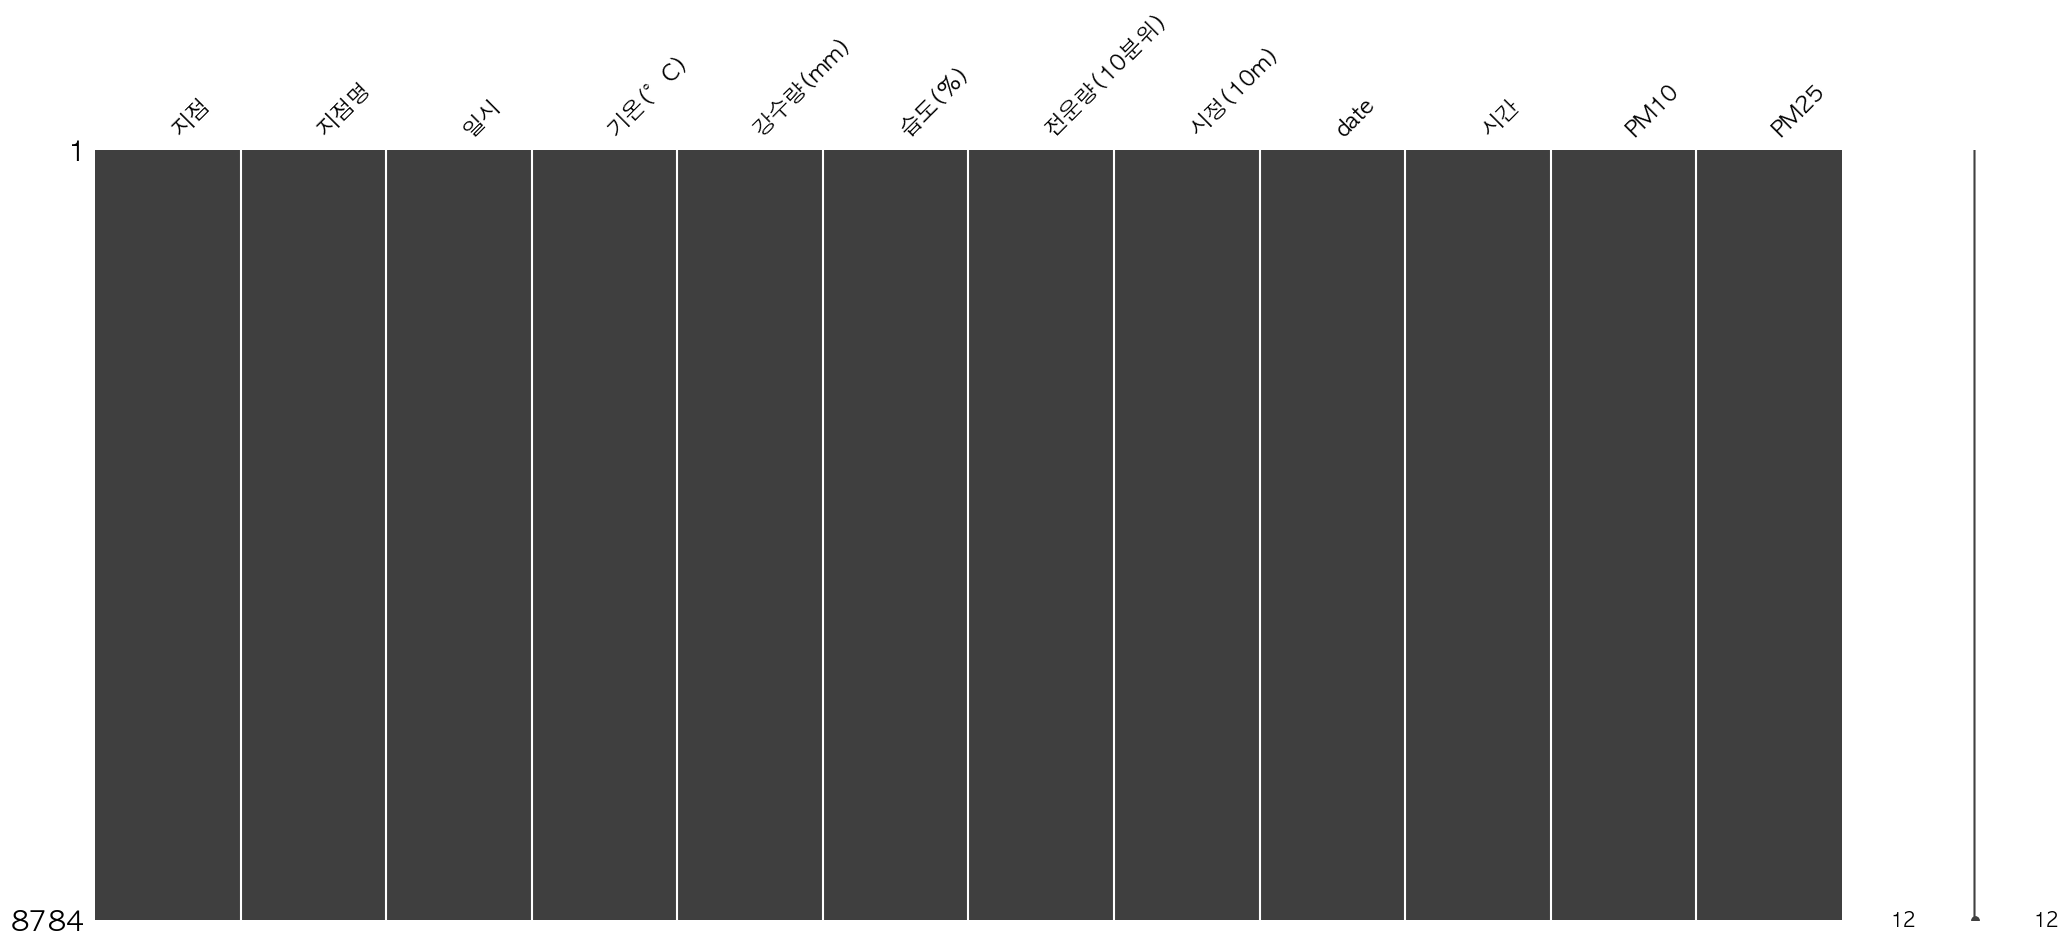

In [64]:
msno.matrix(weather)

In [65]:
jamsil5_rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57446 entries, 0 to 57445
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   대여 대여소번호  57446 non-null  int64         
 1   대여 대여소명   57446 non-null  object        
 2   년도        57446 non-null  int32         
 3   월         57446 non-null  int32         
 4   일         57446 non-null  int32         
 5   시간        57446 non-null  int32         
 6   휴일여부      57446 non-null  int64         
 7   요일        57446 non-null  int32         
 8   date      57446 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(5), int64(2), object(1)
memory usage: 2.8+ MB


In [66]:
jamsil5_return_weather=pd.merge(jamsil5_return, weather.iloc[:,3:], on=['date','시간'])

In [67]:
jamsil5_rent_weather=pd.merge(jamsil5_rent, weather.iloc[:,3:], on=['date','시간'])

In [68]:
jamsil5_rent_weather

,대여 대여소번호,대여 대여소명,년도,월,일,시간,휴일여부,요일,date,기온(°C),강수량(mm),습도(%),전운량(10분위),시정(10m),PM10,PM25
0,1222,잠실새내역 5번 출구 뒤,2024,4,1,0,0,0,2024-04-01,9.5,0.0,50,0,2694,54.0,13.0
1,1222,잠실새내역 5번 출구 뒤,2024,4,1,1,0,0,2024-04-01,8.6,0.0,53,0,2631,54.0,15.0
2,1222,잠실새내역 5번 출구 뒤,2024,4,1,2,0,0,2024-04-01,7.7,0.0,53,0,2936,57.0,16.0
3,1222,잠실새내역 5번 출구 뒤,2024,4,1,3,0,0,2024-04-01,7.2,0.0,54,0,2907,54.0,16.0
4,1222,잠실새내역 5번 출구 뒤,2024,4,1,3,0,0,2024-04-01,7.2,0.0,54,0,2907,54.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51435,1222,잠실새내역 5번 출구 뒤,2023,9,30,23,2,5,2023-09-30,18.2,0.0,67,0,2000,51.0,16.0
51436,1222,잠실새내역 5번 출구 뒤,2023,9,30,23,2,5,2023-09-30,18.2,0.0,67,0,2000,51.0,16.0
51437,1222,잠실새내역 5번 출구 뒤,2023,9,30,23,2,5,2023-09-30,18.2,0.0,67,0,2000,51.0,16.0
51438,1222,잠실새내역 5번 출구 뒤,2023,9,30,23,2,5,2023-09-30,18.2,0.0,67,0,2000,51.0,16.0


In [69]:
jamsil5_return_weather

,반납대여소번호,반납대여소명,년도,월,일,시간,휴일여부,요일,date,기온(°C),강수량(mm),습도(%),전운량(10분위),시정(10m),PM10,PM25
0,1222.0,잠실새내역 5번 출구 뒤,2024,4,1,0,0,0,2024-04-01,9.5,0.0,50,0,2694,54.0,13.0
1,1222.0,잠실새내역 5번 출구 뒤,2024,4,1,0,0,0,2024-04-01,9.5,0.0,50,0,2694,54.0,13.0
2,1222.0,잠실새내역 5번 출구 뒤,2024,4,1,1,0,0,2024-04-01,8.6,0.0,53,0,2631,54.0,15.0
3,1222.0,잠실새내역 5번 출구 뒤,2024,4,1,2,0,0,2024-04-01,7.7,0.0,53,0,2936,57.0,16.0
4,1222.0,잠실새내역 5번 출구 뒤,2024,4,1,2,0,0,2024-04-01,7.7,0.0,53,0,2936,57.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52315,1222.0,잠실새내역 5번 출구 뒤,2023,9,30,23,2,5,2023-09-30,18.2,0.0,67,0,2000,51.0,16.0
52316,1222.0,잠실새내역 5번 출구 뒤,2023,9,30,23,2,5,2023-09-30,18.2,0.0,67,0,2000,51.0,16.0
52317,1222.0,잠실새내역 5번 출구 뒤,2023,10,1,0,1,6,2023-10-01,17.1,0.0,69,0,2000,46.0,10.0
52318,1222.0,잠실새내역 5번 출구 뒤,2023,10,1,0,1,6,2023-10-01,17.1,0.0,69,0,2000,46.0,10.0


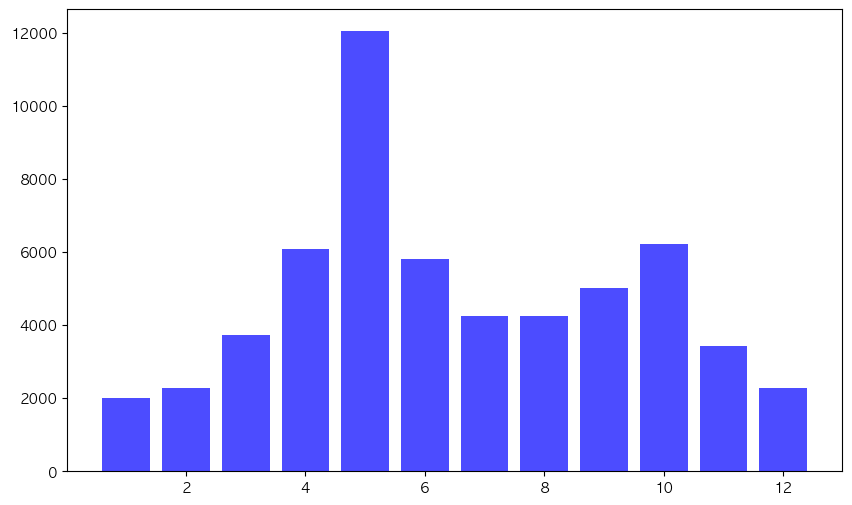

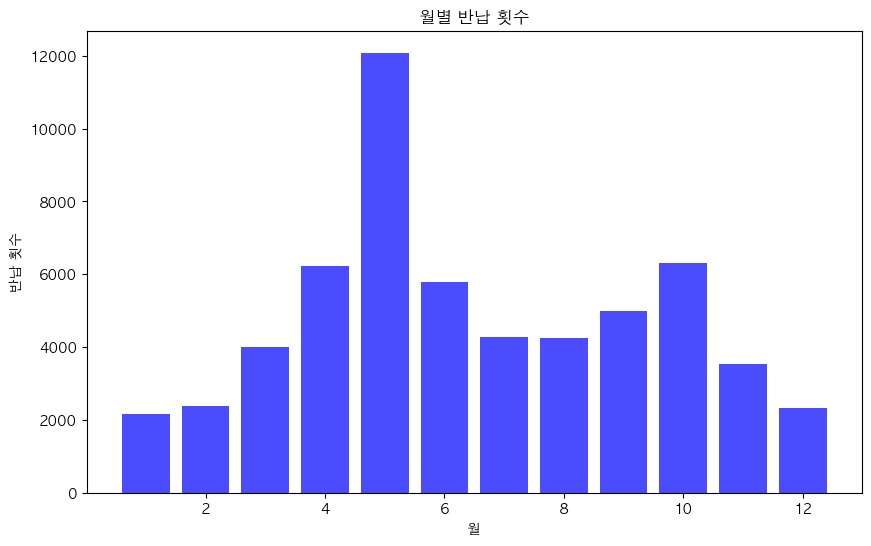

In [70]:
monthly_counts_rent = jamsil5_rent.groupby('월').size().reset_index(name='대여횟수')

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(monthly_counts_rent['월'], monthly_counts_rent['대여횟수'], color='blue', alpha=0.7)


monthly_counts_return = jamsil5_return.groupby('월').size().reset_index(name='반납횟수')

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(monthly_counts_return['월'], monthly_counts_return['반납횟수'], color='blue', alpha=0.7)
plt.title('월별 반납 횟수')
plt.xlabel('월')
plt.ylabel('반납 횟수')
plt.show()


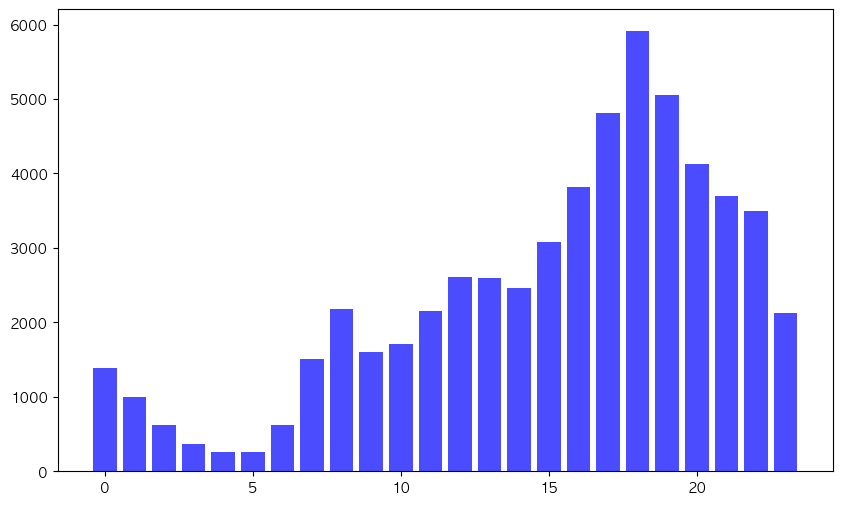

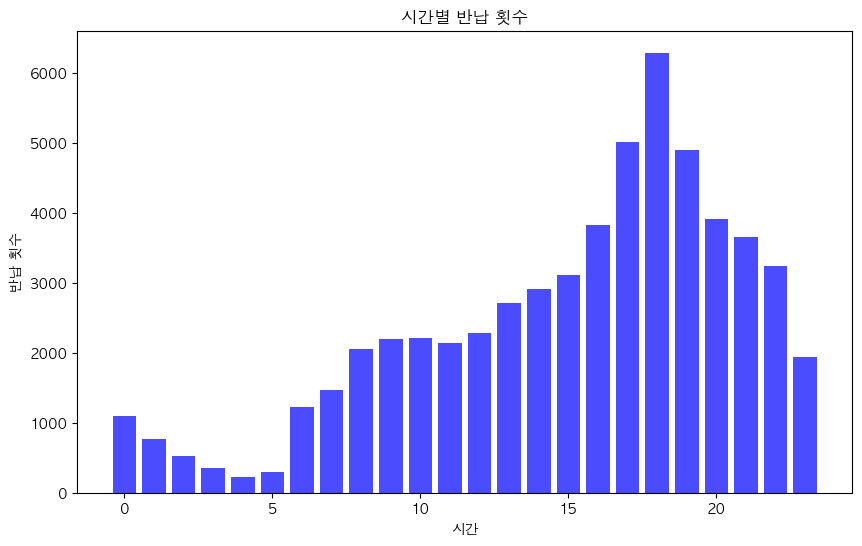

In [71]:
monthly_counts_rent = jamsil5_rent.groupby('시간').size().reset_index(name='대여횟수')

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(monthly_counts_rent['시간'], monthly_counts_rent['대여횟수'], color='blue', alpha=0.7)


monthly_counts_return = jamsil5_return.groupby('시간').size().reset_index(name='반납횟수')

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(monthly_counts_return['시간'], monthly_counts_return['반납횟수'], color='blue', alpha=0.7)
plt.title('시간별 반납 횟수')
plt.xlabel('시간')
plt.ylabel('반납 횟수')
plt.show()


In [72]:
jamsil5_rent_weather.groupby('요일').size().reset_index(name='대여횟수').head(2)
jamsil5_return_weather.groupby('요일').size().reset_index(name='반납횟수').head(2)

,요일,반납횟수
0,0,6967
1,1,7056


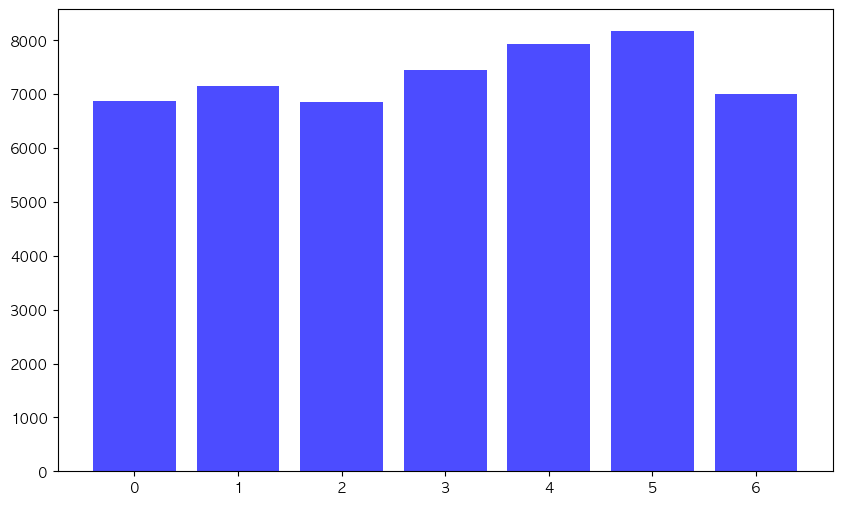

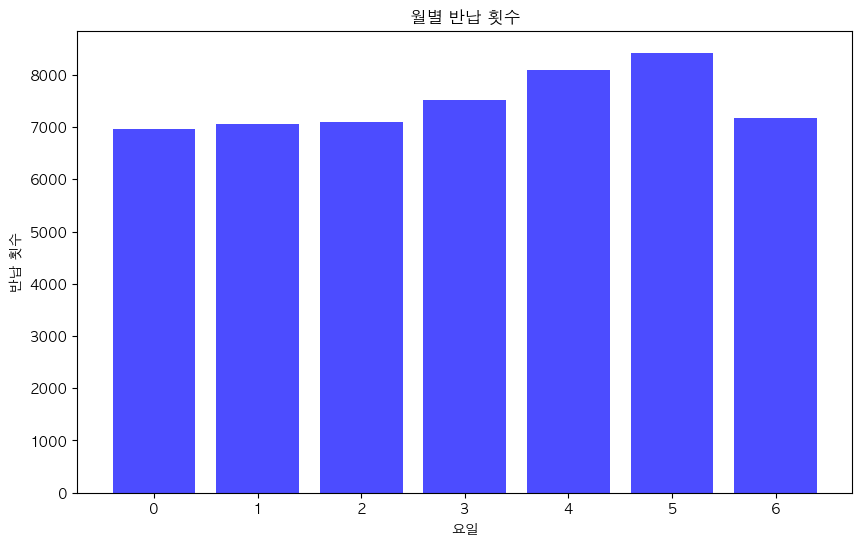

In [73]:
day_counts_rent = jamsil5_rent_weather.groupby('요일').size().reset_index(name='대여횟수')

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(day_counts_rent['요일'], day_counts_rent['대여횟수'], color='blue', alpha=0.7)


day_counts_return = jamsil5_return_weather.groupby('요일').size().reset_index(name='반납횟수')

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(day_counts_return['요일'], day_counts_return['반납횟수'], color='blue', alpha=0.7)
plt.title('월별 반납 횟수')
plt.xlabel('요일')
plt.ylabel('반납 횟수')
plt.show()

<Axes: >

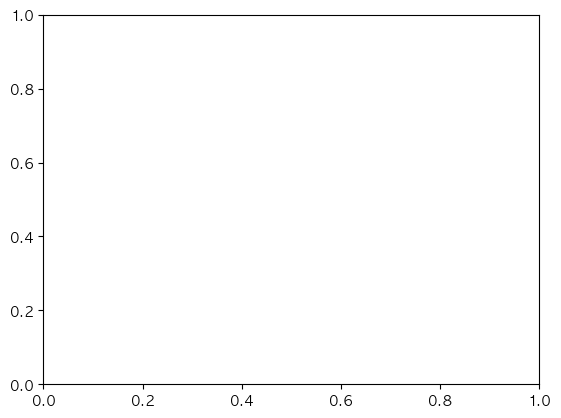

In [74]:
sns.scatterplot(
)

In [75]:
# jamsil5_rent_weather.to_csv('../../data/잠실새내대여.csv',index=False)
# jamsil5_return_weather.to_csv('../../data/잠실새내반납.csv',index=False)

-----------------------------------------------------

In [76]:
jamsil5_rent_weather

,대여 대여소번호,대여 대여소명,년도,월,일,시간,휴일여부,요일,date,기온(°C),강수량(mm),습도(%),전운량(10분위),시정(10m),PM10,PM25
0,1222,잠실새내역 5번 출구 뒤,2024,4,1,0,0,0,2024-04-01,9.5,0.0,50,0,2694,54.0,13.0
1,1222,잠실새내역 5번 출구 뒤,2024,4,1,1,0,0,2024-04-01,8.6,0.0,53,0,2631,54.0,15.0
2,1222,잠실새내역 5번 출구 뒤,2024,4,1,2,0,0,2024-04-01,7.7,0.0,53,0,2936,57.0,16.0
3,1222,잠실새내역 5번 출구 뒤,2024,4,1,3,0,0,2024-04-01,7.2,0.0,54,0,2907,54.0,16.0
4,1222,잠실새내역 5번 출구 뒤,2024,4,1,3,0,0,2024-04-01,7.2,0.0,54,0,2907,54.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51435,1222,잠실새내역 5번 출구 뒤,2023,9,30,23,2,5,2023-09-30,18.2,0.0,67,0,2000,51.0,16.0
51436,1222,잠실새내역 5번 출구 뒤,2023,9,30,23,2,5,2023-09-30,18.2,0.0,67,0,2000,51.0,16.0
51437,1222,잠실새내역 5번 출구 뒤,2023,9,30,23,2,5,2023-09-30,18.2,0.0,67,0,2000,51.0,16.0
51438,1222,잠실새내역 5번 출구 뒤,2023,9,30,23,2,5,2023-09-30,18.2,0.0,67,0,2000,51.0,16.0


In [77]:
rent_test=pd.DataFrame({'대여 횟수':jamsil5_rent_weather.groupby(['월','시간','휴일여부']).size()}).reset_index()


In [78]:
jamsil5_rent_weather

,대여 대여소번호,대여 대여소명,년도,월,일,시간,휴일여부,요일,date,기온(°C),강수량(mm),습도(%),전운량(10분위),시정(10m),PM10,PM25
0,1222,잠실새내역 5번 출구 뒤,2024,4,1,0,0,0,2024-04-01,9.5,0.0,50,0,2694,54.0,13.0
1,1222,잠실새내역 5번 출구 뒤,2024,4,1,1,0,0,2024-04-01,8.6,0.0,53,0,2631,54.0,15.0
2,1222,잠실새내역 5번 출구 뒤,2024,4,1,2,0,0,2024-04-01,7.7,0.0,53,0,2936,57.0,16.0
3,1222,잠실새내역 5번 출구 뒤,2024,4,1,3,0,0,2024-04-01,7.2,0.0,54,0,2907,54.0,16.0
4,1222,잠실새내역 5번 출구 뒤,2024,4,1,3,0,0,2024-04-01,7.2,0.0,54,0,2907,54.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51435,1222,잠실새내역 5번 출구 뒤,2023,9,30,23,2,5,2023-09-30,18.2,0.0,67,0,2000,51.0,16.0
51436,1222,잠실새내역 5번 출구 뒤,2023,9,30,23,2,5,2023-09-30,18.2,0.0,67,0,2000,51.0,16.0
51437,1222,잠실새내역 5번 출구 뒤,2023,9,30,23,2,5,2023-09-30,18.2,0.0,67,0,2000,51.0,16.0
51438,1222,잠실새내역 5번 출구 뒤,2023,9,30,23,2,5,2023-09-30,18.2,0.0,67,0,2000,51.0,16.0


In [79]:
rent_test

,월,시간,휴일여부,대여 횟수
0,1,0,0,40
1,1,0,1,29
2,1,0,2,2
3,1,1,0,29
4,1,1,1,15
...,...,...,...,...
778,12,22,1,28
779,12,22,2,3
780,12,23,0,52
781,12,23,1,34


In [80]:
jamsil5_rent_weather.iloc[:,3:].head(2)

,월,일,시간,휴일여부,요일,date,기온(°C),강수량(mm),습도(%),전운량(10분위),시정(10m),PM10,PM25
0,4,1,0,0,0,2024-04-01,9.5,0.0,50,0,2694,54.0,13.0
1,4,1,1,0,0,2024-04-01,8.6,0.0,53,0,2631,54.0,15.0


In [81]:
pd.merge(rent_test,jamsil5_rent_weather.iloc[:,3:].head(2), on=['월','시간'] )

,월,시간,휴일여부_x,대여 횟수,일,휴일여부_y,요일,date,기온(°C),강수량(mm),습도(%),전운량(10분위),시정(10m),PM10,PM25
0,4,0,0,80,1,0,0,2024-04-01,9.5,0.0,50,0,2694,54.0,13.0
1,4,0,1,56,1,0,0,2024-04-01,9.5,0.0,50,0,2694,54.0,13.0
2,4,0,2,5,1,0,0,2024-04-01,9.5,0.0,50,0,2694,54.0,13.0
3,4,1,0,58,1,0,0,2024-04-01,8.6,0.0,53,0,2631,54.0,15.0
4,4,1,1,36,1,0,0,2024-04-01,8.6,0.0,53,0,2631,54.0,15.0
5,4,1,2,9,1,0,0,2024-04-01,8.6,0.0,53,0,2631,54.0,15.0


In [ ]:
# df_jamsil.to_csv('../../data/잠실새내통합.csv',index=False)

In [159]:


## csv 파일의 컬럼 올바르게 수정
def reset_columns(dataframe):
    columns=dataframe.columns
    dataframe=dataframe.drop(columns=dataframe.columns[-1],axis=1)
    dataframe=dataframe.reset_index()
    dataframe.columns=columns
    return dataframe



def extract_and_concat(csv_folder, target_column, target_values):
    path = f'{csv_folder}/*.csv'
    all_data = []
    
    for filename in glob.glob(path):
        df = pd.read_csv(filename)
        df=reset_columns(df)
        if target_column in df.columns:
            filtered_df = df[df[target_column].isin(target_values)]
            if not filtered_df.empty:
                all_data.append(filtered_df)
    
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        return combined_df.sort_values([combined_df.columns[0],combined_df.columns[1]],ascending=True)
    else:
        return pd.DataFrame()


In [160]:

# 사용 예시
csv_folder = '../../data/생활인구'  # CSV 파일들이 있는 폴더 경로
selected_column = '행정동코드'  # 추출하고자 하는 컬럼 이름
selected_values = [11710650,11710670,11710680,11710690,11710710,11710720]  # 추출하고자 하는 값들

population = extract_and_concat(csv_folder, selected_column, selected_values)

if not population.empty:
    print('병합완료')
else:
    print('추출된 데이터가 없습니다.')

병합완료


In [162]:
population.to_csv('../../data/잠실동생활인구.csv',index=False)